# Checkpoint 1: Neural networks and deep learning
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)

In this checkpoint exercise, we will use neural networks to predict the **type** of weather *given* the available ground observations. You will be using observation data from **June 2019** across all UK Met Office weather stations.

### Notes on the Dataset
* You will be using weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 
* `Null` values for some features are expected (e.g. Wind Gust)
* Data import and preparation is already provided 


This week, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** Think of these as LEGO blocks; you have the ones you need but may look up how to "assemble" them.

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 9 October 2021** 
- This CP exercise sheet is divided into **6 sections**, corresponding to parts of the lecture, giving a maximum of **10 marks** in total:

| <p align='left'> Title                         | <p align='left'> Exercise nos. | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Conceptual questions               | <p align='left'>  1–5  | <p align='left'> 2.5 |
| <p align='left'> 2. Data preprocessing and RandomForest                | <p align='left'>  6–9  | <p align='left'> 2.5 |
| <p align='left'> 3. Neural networks in `scikit-learn`  | <p align='left'>  10–11 | <p align='left'> 1.5 | 
| <p align='left'> 4. Neural networks in `Keras`         | <p align='left'> 12–13 | <p align='left'> 2 |
| <p align='left'> 5. Regularisation                     | <p align='left'> 14–15 | <p align='left'> 1.5 |
| <p align='left'> 6. Bonus: Hyperparameter optimisation | <p align='left'> 16 | <p align='left'> 1.0 (\*bonus\*) |
| <p align='left'> **Total** | | <p align='left'> **10 + 1** |

- The total number of marks allocated for this CP is 10,
    - 1 additional mark can be given (maximimally up to 10 marks in total) for "bonus" exercise on hyperparameter optimisation. If you are pressed for time, focus on the first five sections; those are the core ones.
    - Half marks may be deducted for code legibility (i.e. very difficult to tell what you are doing), or for badly formated plots (i.e. no legends, axis labels etc.). The TAs will use their discression for this so comment code when applicable and keep relevant information in your plots.

_Note:_ You can suppress double-printing of plots from the `plot` module by either _(a)_ adding a semicolon after the function call (_i.e._ `plot.<method>(...);`), or _(b)_ by capturing the return `pyplot.Figure` object as a variable (_i.e._ `fig = plot.<method>(...)`).

## Preamble

In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# Suppress unnecessary ConvergenceWarnings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make workbook reproducible
seed=5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

C:\Users\betc\anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\betc\anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\betc\anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\betc\anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework

In [2]:
# Load in the prepared weather data
obs = pd.read_csv('weather(1).csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [3]:
obs.shape

(106553, 17)

In [4]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


For this exercise we will use **8** input features (provided) and clean the data:

In [5]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [6]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape

(86313, 9)

## 1. Conceptual questions (2.5 Marks)
---
This section covers **5** exercises on conceptual understanding of neural networks.

#### 1. Which are the most used activation functions and why do we (typically) need non-linear activation functions in neural networks? (0.5 mark)

The most used activation functions are sigmoid, tanhx, softmax and ReLU

The activation function does non linear transformation to the input making it more capable to learn and perform more complex tasks. Therefore we need to introduce non-linearity to neural networks for many reasons:
1. Hidden layers become useless if we use linear activation functions, because the composition of linear functions is linear
2. You cannot use backpropagation to train a model using linear activation functions, as the derivative would give a constant. This C has no relation to the input so it cannot feed back to understand which weightings are more important for prediction

#### 2. Why do we need deep neural networks and which are the main differences between deep and shallow learning? (0.5 Mark)

Shallow neural networks describes neural networks that have only one hidden layer, as opposed to deep neural networks which have two or more hidden layers, often of various types. Deep neural networks 'learn better' as they continue increasing performance with amount of data where shallow learning plateaus. 

Shallow learning requires manual feature engineering and is unable to exploit high dimensional data, whereas deep learning has capacity to exploit high dimensional data and perform feature extraction and deep combination simultaneously, without the need for manual feature engineering.

Deep neural networks are able to make abstractions of features of input and make predictions based on these, it is a higher level of learning than shallow learning

#### 3. Discuss the Bias-variance trade-off and its relation to underfitting and overfitting of a model. Which are the characteristics of an ideal model?  (0.5 mark)

The bias error is an error from incorrect assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs, this is underfitting, when this bias is high and variance is low.
The variance is an error from sensitivity to small fluctuations in the training set. High variance may result from an algorithm modeling the random noise in the training data. This is overfitting, when a model has high variance and low bias. 
The variance of the parameter estimated across samples can be reduced by increasing the bias in the estimated parameters.
Ideal model has low variance low bias.

#### 4. Given a neural network with 4 input nodes, 2 layers with 5 nodes each, and 1 output node, what is the total number of free (trainable) parameters in the network? Does it matter which activation function(s) are used?  (0.5 mark)

(4*5 + 5*5 + 5*1) + (5+5+1) = 61 free/trainable parameters

The activation function chosen should match to the type of desired output. It needs to be non-linear in order to allow for backpropagation and train the model, it should be differentiable to allow multi layer models to learn non linear relations.

It does matter which activation functions are used as they are each suitable specific things: ReLU for regressing (+ve), Sigmoid for binary probability, softmax for multiclass probability. ReLU is fast but maps all negative values to zero so cannot be used with negative inputs, sigmoid and tanh can saturate, so the activation has to be chosen depending on input and type of output.


#### 5. What are appropriate choice for _(a)_ the number of output nodes and _(b)_ output activation function(s) for each of the following tasks, and why? (0.5 mark)

1. Regression of the $x$, $y$, and $z$ coordinates of a single particle in an arbitrary coordinate system
2. Regression of particle energy of a single particle
3. Classification of two processes (signal vs. background)
4. Classification among *N* classes (dog vs. cat vs. fish vs. ...)

a) 
1) three, due to the three dimensions (x,y,z)

2) one (scalar value of energy)

3) two (binary classification)

4) N no. nodes (N classes of animal)

b)
1. tanh (the only one that can give a range of pos and neg values)
2. ReLU (suitable for non negative regression, and energy is a positive quantity)
3. Sigmoid (goes between 0 and 1 so good for binary classification)
4. Softmax (Multiclass classification probability)

## 2. Data preprocessing and RTs (2.5 mark)
---
This section covers **4** exercises on data preparation, feature standardisation, and dataset splitting.

In [7]:
# Relevant import(s) for this section
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

---
**_A comment on target format and one-hot encoding:_** By default, the target column (`Type`) contains one integer (0, 1, or 2) for each example, the integer specifying one of three possible types of weather. However, for doing multi-class classification (which this is), we want our neural network to have one output node per class (_i.e._ 3 output nodes in this case), such that the activation of each output node is interpreted as the likelihood for a given sample being of the type in question. Therefore, the target should also be a 3-element vector for each sample; this vector should be all zeros, except for a $1$ at the index corresponding to the type in question. This is called **one-hot encoding**, and a few examples are shown below:

- type = 0 $\to$ one-hot = $[1, 0, 0]$ for 3 classes
- type = 1 $\to$ one-hot = $[0, 1, 0]$ for 3 classes
- type = 2 $\to$ one-hot = $[0, 0, 1]$ for 3 classes

This is the target towards which a neural network classifier is trained: That is, ideally, for an example of type 0, the network will output a large activation ($\approx 1$) on the first output node (interpreted as a large likelihood for the first weather type), and very small activations ($\ll 1$) on the two other output nodes (intepreted as small likelihoods for the two other weather types); and so on.

The same type of one-hot encoding can be performed for any number of target classes $N_{c}$, which just results in $N_{c}$-element target vectors with a single non-zero entry each.

To be user friendly, however, `scikit-learn` allows us to use integer targets for multi-class classification — it does the one-hot encoding for us "under the hood." Similarly, `keras`, _can_ also allow us to use integer targets for multi-class classification, provided we use the appropropriate loss (`sparse_categorical_crossentropy`). Otherwise (if we use `categorical_crossentropy` loss), it expects one-hot encoded targets. Which approach you choose is up to you — but now you know what goes on.

---

#### 6. Prepare the feature and target arrays (0.5 mark)
- Randomly sample **3,500** observations per weather type (**10,500** observations in total) from `dataset` into a new `pandas.DataFrame`; call it `sample`.
- One-hot encode the **wind direction** variable (_i.e._ $N$ (north) to $[1, 0, \ldots, 0]$, $NNE$ (north north east) to $[0, 1, \ldots, 0]$, _etc._ ), to allow us to input it to the neural network. The exact order of the encoding (_i.e._ which direction corresponds to which index) doesn't matter. *Hint:*
  - *Either:* Use the scikit-learn `ColumnTransformer` with the `OneHotEncoder` applied to the `WindDirection` column, and let the remainder of the features pass through un-transformed.
  - *Or:* Use the `OneHotEncoder` class directly on the `WindDirection` column (use `sparse=False` in the `OneHotEncoder` constructor), and then concatenate with a `numpy.array` containing the remaining features.
- Define `numpy.arrays` named `X` and `y` containing the training features (the 7 unmodified ones plus the one-hot encoded wind directions) and target, respectively.
- Argue whether the shapes of `X` and `y` are as expected/as they should be.

In [8]:
#group by type of weather (0, 1 or 2)
#create random forest of 3500 samples
sample = dataset.groupby("Type").sample(n=3500, random_state=1)
sample

,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity,WindDirection,Type
30399,52.242,99.0,20.5,11000.0,3.0,1014.0,54.2,ESE,0
45306,51.479,25.0,13.0,45000.0,3.0,1020.0,68.0,NE,0
84305,51.279,72.0,21.2,30000.0,9.0,1025.0,38.1,NNW,0
87099,52.949,21.0,17.6,40000.0,6.0,1026.0,70.3,NNW,0
18725,54.501,255.0,7.3,30000.0,2.0,1019.0,88.2,WNW,0
...,...,...,...,...,...,...,...,...,...
54315,55.050,285.0,9.7,11000.0,9.0,1010.0,94.0,S,2
15718,53.175,68.0,11.1,14000.0,13.0,1019.0,89.7,NNE,2
7733,56.326,35.0,14.4,1200.0,1.0,1019.0,100.0,W,2
112,58.954,26.0,10.5,400.0,9.0,1017.0,100.0,ESE,2


In [9]:
#one hot encode wind direction so each type is given an assigned index in a matrix ie N = [1,0,0..]
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), ['WindDirection'])], remainder='passthrough')

In [10]:
#apply encoder to sample
sample2 = np.array(columnTransformer.fit_transform(sample), dtype = np.int)
sample2

array([[   0,    0,    1, ..., 1014,   54,    0],
       [   0,    0,    0, ..., 1020,   68,    0],
       [   0,    0,    0, ..., 1025,   38,    0],
       ...,
       [   0,    0,    0, ..., 1019,  100,    2],
       [   0,    0,    1, ..., 1017,  100,    2],
       [   0,    0,    0, ..., 1007,   84,    2]])

In [11]:
#create new array x which discards the 'type' column as this will be our target
X = np.array(sample2[:,0:-1])
X.shape

(10500, 23)

In [12]:
#assign target, y, to last column
y = sample2[:,-1]
y

array([0, 0, 0, ..., 2, 2, 2])

#### 7. Train a Random Forest and evaluate the performance (1 mark)

Decision trees work well with a mixture of features (of different scales, and bot binary and continuos), so we will train a random forest to do the job of categorisation.

You are given the train test split:

In [13]:
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)


(7350, 23) (3150, 23)
(7350,) (3150,)


1. Train a RandomForestClassifier with 1000 estimators, `gini` seperation criteria, and max depth 4.
2. Check the overal accuaracy on the testing set

3. Use the confusion_matrix method to return the confusion matrix normalised over the true lables, i.e. sum over rows should sum to 100%. Use the given colormap to plot the confusion matrix in a heatmap.
    - Define the axis tick names to represent Clear, Cloudy or Precip
    - Use suitable x and y axis labels
    
4. What are the true positive rates for clear, cloudy and perp? What is the probability that rain is forcast given that the day is clear?
5. Which features does the random forest deem the most important?

In [14]:
# Create Decision Tree classifer object with these parameters
rf = RandomForestClassifier(n_estimators=1000,criterion = 'gini',max_depth = 4)
# Train Decision Tree Classifer
rf = rf.fit(x_train,y_train)
# Predict the response for test dataset
y_pred = rf.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = rf.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))

Accuracy Training: 0.6693877551020408
Accuracy Testing: 0.653015873015873


In [15]:
#create a confusion matrix with test and predicted samples and normalise them in the true label direction
cf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize='true')

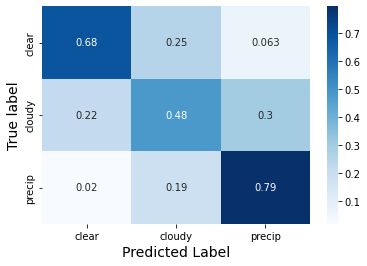

In [16]:
#create seaborn heatmap to visualise data. rows add to 100%
categories = ['clear', 'cloudy','precip']
sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label",fontsize=14)
plt.ylabel("True label",fontsize=14)
plt.show()

True positive values: clear 68%, cloudy 48%, precip 79% (the values on the diagonal)

What is the probability that rain is forcast given that the day is clear? ANS: 6.3%

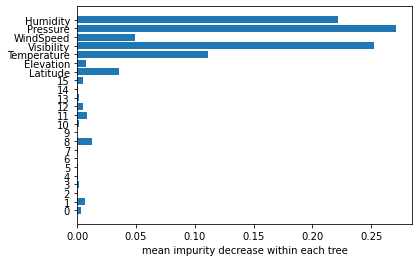

In [17]:
# Given plotting example for feature importance
plt.barh(range(23), rf.feature_importances_);
plt.yticks(range(23), list(range(16))+features[:-1]);
plt.xlabel('mean impurity decrease within each tree');

Which features does the random forest deem the most important: Pressure, visibility, humidity, temp

#### 8. Standardise the relevant features (0.5 mark)

_Note:_ You shouldn't standardise the one-hot encoded wind directions; they already have the desired format. Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
- Hint:

    - Use the scikit-learn `StandardScaler`
    - Or use the scikit-learn `MinMaxScaler`

- Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - The number of columns should match, and depending on the choice of standardisation, the last 7 columns should either have:
      - (Using `StandardScaler`) means = 0 and standard deviations = 1; or
      - (Using `MinMaxScaler`) min = 0, max = 1

In [18]:
#check x dimensions, we want all columns that don't include one-hot-encoded wind direction
X[:,16:23] 

array([[  52,   99,   20, ...,    3, 1014,   54],
       [  51,   25,   13, ...,    3, 1020,   68],
       [  51,   72,   21, ...,    9, 1025,   38],
       ...,
       [  56,   35,   14, ...,    1, 1019,  100],
       [  58,   26,   10, ...,    9, 1017,  100],
       [  57,   65,   12, ...,   15, 1007,   84]])

In [19]:
scaler = StandardScaler()

In [20]:
#apply standard scaler to new X values and check mean is 0 and std is 1 for all columns
X_scaled = StandardScaler().fit_transform(X[:,16:23])
Xmean = np.mean(X_scaled, axis=0)
Xstd = np.std(X_scaled,axis=0)
print(Xmean, Xstd)

[-4.66796971e-15 -1.55219752e-17  4.67256921e-15 -6.19996118e-15
 -2.03044354e-14 -1.98556727e-14  9.38878604e-15] [1. 1. 1. 1. 1. 1. 1.]


#### 9. Split the dataset into a training and a testing part (0.5)

Reserve **30%** of data for testing. Check whether the resulting arrays have the expected shapes.

In [21]:
#add the wind directions back onto the now scaled x
X_scaled = np.concatenate([X[:,0:16],X_scaled],axis=1)
## split dataset into training set and test set
x2_train, x2_test, y2_train, y2_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape)

(7350, 23) (3150, 23)


## 3. Neural networks in `scikit-learn` (1.5 mark)
---
This section covers **2** exercises on constructing and training neural networks using the `scikit-learn` library, as well as evaluating neural network performance. `scikit-learn` provide many, very easy to use ML algorithms, including neural networks. These are called `MLPClassifier` (MLP = multi-layer perceptron; a historic name for densely connected, feed-forward neural networks) when used for classification, and `MLPRegressor` when used for regression. We will focus on the former for now.

In [22]:
# Relevant import(s) for this section
from sklearn.neural_network import MLPClassifier

#### 10. Construct and train a neural network  (1 mark)

- Create an `MLPClassifier` which
    - has **1 hidden layer of 50 neurons** 
    - has **no regularization term**
    - trains for a maximum of **100 epochs** 
    - uses a batch size of **32**
- Fit the classifier using the standard `.fit()` member method.
- Plot the loss function value as a function of number of epochs (0.5 of mark).
  You can access the loss history through the `.loss_curve_` attribute of the `MLPClassifier` instance. 

In [23]:
#create mlp classifier with 50 neurons in the hidden node, batch size 32 and 100 epochs
mlp = MLPClassifier(hidden_layer_sizes=(50,), batch_size=32, max_iter=100, alpha=False)
#apply mlp to x and y
mlp = mlp.fit(X_scaled, y)

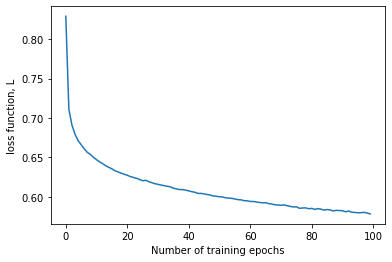

In [24]:
#plot loss curve
loss = mlp.loss_curve_
epochs = range(len(loss))
plt.plot(epochs,loss)
plt.xlabel('Number of training epochs')
plt.ylabel('loss function, L');

#### 11. Performance evaluation (0.5 mark)

- Using the testing dataset: 
    - Compute the overall accuracy for the classifier using the `MLPClassifier`'s `.score()` member method for both testing and training datasets.
    - Compute the confusion matrix (normalised in true labels), and plot it 
- Discuss the results

In [25]:
#check over all accuracy with .score() for both testing and training (scaled) data
score_x = mlp.score(x2_test,y2_test)
score_y = mlp.score(x2_train,y2_train)
print('accuracy of x',score_x)
print('accuracy of y',score_y)

accuracy of x 0.7526984126984126
accuracy of y 0.7476190476190476


In [26]:
#generate predicted y values from training set using .predict()
y2_pred = mlp.predict(x2_train)

In [27]:
#confusion matrix for training data,compared with predicted values
cf_matrix2 = confusion_matrix(y2_train,y2_pred, labels=None, sample_weight=None, normalize='true')

array([[0.81382979, 0.15016367, 0.03600655],
       [0.2026862 , 0.57671958, 0.22059422],
       [0.0163332 , 0.13066558, 0.85300122]])

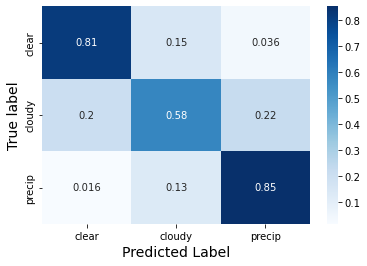

In [28]:
sns.heatmap(cf_matrix2, annot=True, cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label",fontsize=14)
plt.ylabel("True label",fontsize=14)
plt.show()

In [29]:
#generate predicted y values from test set using .predict()
#confusion matrix for testing data,compared with predicted values
y3_pred = mlp.predict(x2_test)
cf_matrix3 = confusion_matrix(y2_test,y3_pred, labels=None, sample_weight=None, normalize='true')

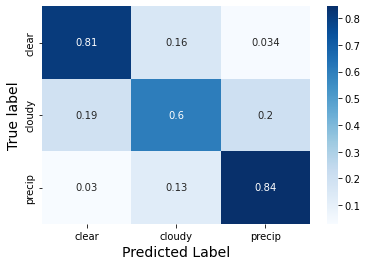

In [30]:
sns.heatmap(cf_matrix3, annot=True, cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label",fontsize=14)
plt.ylabel("True label",fontsize=14)
plt.show()

## 4. Neural networks in `Keras` (2 marks)
---
This section covers **2** exercises on constructing and training neural networks using the `Keras` library. `scikit-learn` is very easy to use, but libraries like `Keras` provide a lot more flexibility, which is why we will be using these extensively in the last two units of the _'Data science tools and machine learning'_ track.

In [31]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

#### 12. Construct a neural network in `Keras` (1 mark)

- Create a `keras.Model` using the **Keras functional API**. The network should have:
    - An input layer with the same number of nodes as the number of features in `X`.
    - A single, densely connected hidden layer with **50 nodes** equipped with **ReLU activation**.
    - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
- Compile the model the using the **Adam optimiser**, add `'accuracy'` as metric, and use either:
    - `categorical_crossentropy` loss, if you have one-hot encoded the targets `y`, or
    - `sparse_categorical_crossentropy` loss if you hare using integer-valued targets.
- Use the `.summary()` member method to print an overview of the model you have created, explain the output.

In [32]:
#input layer with same number of nodes as features in x (23)
inputs = tf.keras.Input(shape=(23,))
#single hidden layer with 50 nodes #reLU
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(inputs)
#A densely connected output layer with 3 nodes equipped with softmax activation
outputs = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(x)
#compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs);
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.Accuracy()])
#print an overview of the model you have created
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


1. Inputs have no bias therefore is 0 parameters
2. Hidden layer has 1200 trainable parameters (23 input weights *50 hidden weights + 50 hidden biases)
3. outputs (50 hidden layer neurons*3 output neurons + 3 output biases) = 153
4. all free and therefore trainable

#### 13. Train a `Keras` neural network (1 mark)

- Use the `.fit()` member method to train the network on the **training dataset** for **100 epochs** with a **batch size of 32**. Use **20% of the data for validation** and make sure to have `Keras` **shuffle** the training data between epochs. Save the fit history by doing `history_mld = .....`
- Print the classification accuracy using the `.evaluate()` member method, for both the training and testing dataset. Comment on the results.
- Plot val_loss and loss functions from the fit history. On the same plot, plot the sklearn curve from the excercise above. Note the sklearn NN does not provide a complementary validation loss history, so only plot the training loss.
- Comment on the results of the overall accuracy compared to the scikit-learn method.

In [34]:
#fitting the model for training data, batch size 32, 100 iterations, shuffled and split 20% for validation
history_mld = model.fit(x2_train,y2_train, batch_size=32, epochs=100, shuffle=True,validation_split=0.2);

Train on 5880 samples, validate on 1470 samples
Epoch 1/100
5880/5880 [==============================] - 0s 46us/sample - loss: 0.8732 - accuracy: 0.0000e+00 - val_loss: 0.7582 - val_accuracy: 0.0000e+00
Epoch 2/100
5880/5880 [==============================] - 0s 32us/sample - loss: 0.7275 - accuracy: 0.0000e+00 - val_loss: 0.7190 - val_accuracy: 0.0000e+00
Epoch 3/100
5880/5880 [==============================] - 0s 35us/sample - loss: 0.7029 - accuracy: 0.0000e+00 - val_loss: 0.7069 - val_accuracy: 0.0000e+00
Epoch 4/100
5880/5880 [==============================] - 0s 32us/sample - loss: 0.6906 - accuracy: 0.0000e+00 - val_loss: 0.6973 - val_accuracy: 0.0000e+00
Epoch 5/100
5880/5880 [==============================] - 0s 32us/sample - loss: 0.6827 - accuracy: 0.0000e+00 - val_loss: 0.6902 - val_accuracy: 0.0000e+00
Epoch 6/100
5880/5880 [==============================] - 0s 33us/sample - loss: 0.6766 - accuracy: 0.0000e+00 - val_loss: 0.6893 - val_accuracy: 0.0000e+00
Epoch 7/100
5880

In [35]:
#checking loss for test vs train
print('training set:',model.evaluate(x2_train,y2_train,verbose=0))
print('test set:',model.evaluate(x2_test,y2_test,verbose=0))

training set: [0.5886096011375894, 0.0]
test set: [0.681476090786949, 0.0]


Training set has smaller loss so is better, as there is more data (70:30 split).

In [38]:
#calculating over all loss and validation loss from shallow keras model using .history[*type of loss*]
val_loss_keras = history_mld.history['val_loss']
loss_keras = history_mld.history['loss']

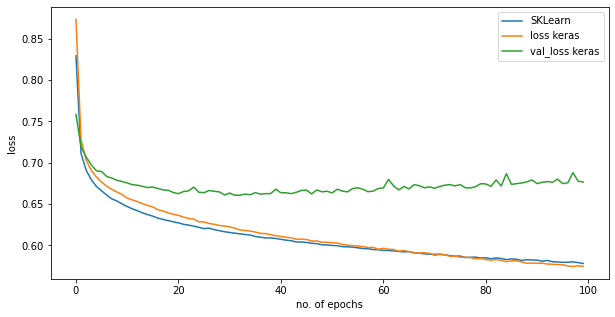

In [62]:
#plotting validation loss and loss in keras vs loss in Sklearn
plt.plot(epochs,loss,label='SKLearn')
plt.plot(loss_keras,label='loss keras')
plt.plot(val_loss_keras,label='val_loss keras')
plt.xlabel('no. of epochs')
plt.ylabel('loss function, L')
plt.legend()
plt.show()

Training loss is minimised, while validation loss saturates. 
In the keras model theres a low loss on training, but high loss on testing datasets. The errors have high variance. Keras model has overfitted the data.
SKLearn model has not overtrained

## 5. Regularisation (1.5 marks)
---
This section covers **2** exercises on the impact of weight regularisaton. Note that $L_{1}$- and $L_{2}$-regularisation may also be applied to the activation of intermediate layers. Also, a similar regularising effect could be achieved using **dropout** regularisation, which you are encouraged to try out, but which we won't study in this CP exercise.

In [40]:
# Relevant import(s) for this section
from tensorflow.python.keras.regularizers import l1_l2

#### 14. Define `Keras` model factory method (0.5 mark)

- Define a python function called `big_model_fn` which takes the followng three arguments:
    - `l1`: A float specifying the $L_{1}$ regularisation factor (default value: 0)
    - `l2`: A float specifying the $L_{2}$ regularisation factor (default value: 0)
    - `name`: A string, specifying the name of the model (default value: None)
- Indside the function, you should:
    - Construct a `Keras` model using the functional API, which has:
        - An input layer with the same number of nodes as the number of features in `X`.
        - **Two** densely connected hidden layer with **100 nodes** each, both equipped with **ReLU activation**.
        - Both hidden layers should be subject to kernel regularisation (_i.e._ weight regularisation) with the regularisation factors specified as an input.
        - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
        - A name given by the corresponding argument.
    - Compile the model in the same way as in **Exercise 14.**
- The function should return the compiled `Keras` model. 

The method will provide a convenient way of constructing and compiling a number of "big"/deep `Keras` models which differ only by their regularisation and name.

In [41]:
def big_model_fn(l1=0, l2=0, name=None):
    inputs = tf.keras.Input(shape=(23,))
    #two hidden layers with 100 nodes each #reLU activation #regularizer takes inputs from function
    #one goes into inputs
    x = tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=l1_l2(l1=l1,l2=l2))(inputs)
    #second goes into the first x (layered into eachother)
    x = tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=l1_l2(l1=l1,l2=l2))(x)
    #A densely connected output layer with 3 nodes equipped with softmax activation
    outputs = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(x)
    #compile the model and return it
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name);
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.Accuracy()])
    return model

In [42]:
#testing function works
model2 = big_model_fn(0.001,0.001,'test')
print(model2.summary())

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2400      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 12,803
Trainable params: 12,803
Non-trainable params: 0
_________________________________________________________________
None


#### 15. Train "big" models with and without regularisation (1 mark)

- Construct three "big" model using the factory method:
     - One with default parameters
     - One with `l1=0.0003` and  `name='Big model (L1-regularised)'`
     - One with `l2=0.003`  and `name='Big model (L2-regularised)'`
- Train each one as in **Exercise 15.**
- Compare first the loss history of the un-regularised "big" model to that of the small model from **Exercise 15** using the `plot.loss()` method. # JUST PLOT LOSS CURVES
- Then, compare the loss histories of all three "big" models with that of the small model.
- Plot the loss and val loss of all 4 models and discuss the results. Target these points:
    - Compare the performance of deep vs shallow models on the testing sets
    - Compare the level of ovetraining (training vs testing loss)
    - Note: Don't be alarmed if the shallow network performs slightly better that the deeper ones, this is dataset dependant.

In [43]:
#constructing three big models, one with no param, one with l1 specified, one with l2
default_param = big_model_fn()
L1_reg = big_model_fn(l1=0.0003, name='Big model (L1-regularised)')
L2_reg = big_model_fn(l2=0.003, name='Big model (L2-regularised)')

##### FROM EX13: Use the .fit() member method to train the network on the training dataset for 100 epochs with a batch size of 32. Use 20% of the data for validation and make sure to have Keras shuffle the training data between epochs. Save the fit history by doing history_mld = .....

In [44]:
#fit training data to each big model for same parameters as before
#obtain loss and validation loss from all big models using .history[]
hist1 = default_param.fit(x2_train,y2_train, batch_size=32, epochs=100, shuffle=True,validation_split=0.2,verbose=0)
loss_default = hist1.history['loss']
val_loss_default = hist1.history['val_loss']

hist2 = L1_reg.fit(x2_train,y2_train, batch_size=32, epochs=100, shuffle=True,validation_split=0.2,verbose=0)
loss_L1 = hist2.history['loss']
val_loss_L1 = hist2.history['val_loss']

hist3 = L2_reg.fit(x2_train,y2_train, batch_size=32, epochs=100, shuffle=True,validation_split=0.2,verbose=0)
loss_L2 = hist3.history['loss']
val_loss_L2 = hist3.history['val_loss']

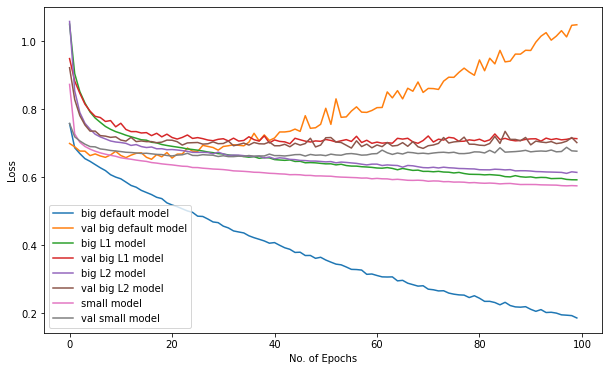

In [61]:
#plot all validation losses and loss for each models to compare them
plt.plot(loss_default,label='big default model')
plt.plot(val_loss_default,label='val big default model')
plt.plot(loss_L1,label='big L1 model')
plt.plot(val_loss_L1,label='val big L1 model')
plt.plot(loss_L2,label='big L2 model')
plt.plot(val_loss_L2,label='val big L2 model')
plt.plot(loss_keras,label='small model')
plt.plot(val_loss_keras,label='val small model')
plt.rcParams['figure.figsize'] = (10,5)
plt.xlabel('No. of Epochs')
plt.ylabel('Loss function')
plt.legend()
plt.show()

In the big model with no regularization, it is largely over trained, thus has the largest split between validation loss and loss. The best model is the big L2 model as it has the smallest split and therefore it has sufficient capacity and is the most ideal model out of the lot.

## 6. Bonus: Hyperparameter optimisation (1\*bonus\* mark)
---

This section covers **1** exercise on the on hyperparameter optimisation. 

In [ ]:
# Relevant import(s) for this section
from sklearn.model_selection import GridSearchCV, cross_val_score

---
_**Comment on simplified hyperparameter optimisation example:**_ You will try to perform a simple optimisation using a grid search

For convenience, we will be using the `scikit-learn` `MLPClassifier` as our base class, but the same principles apply to just about any ML model constructed in any framework. Just as in the examples in the lecture, we will restrict the hyperparameter space to just two dimensions:

* the number of hidden layers, `nb_layers`, and
* the number of nodes per hidden layer, `nb_nodes_per_layer`, which is taken to be the same for all hidden layers for simplicity.

Since the `scikit-learn` neural network classifier class doesn't support these two hyperparameters by default, provided is a simple wrapper class, that works exactly like `MLPClassifier`, it just takes the two parameters above as arguments in the constructor. Don't worry about understanding it in detail. This allows us to call 

In [ ]:
class MLPClassifierWrapper(MLPClassifier):
    """
    Wrapper around `sklearn.neural_network.MLPClassifier` with a convenient set 
    of properties (nb_layers and nb_nodes_per_layer) suitable for hyperparameter 
    optimisation exercises.
    
    Arguments:
        nb_layers: Integer, number of hidden layers
        nb_nodes_per_layer: Number of nodes per hidden layer, taken to be the 
            same for all for convenience.
    """

    def __init__ (self, nb_layers=1, nb_nodes_per_layer=100, **kwargs):
        
        # Member variables
        self._nb_layers = nb_layers
        self._nb_nodes_per_layer = nb_nodes_per_layer  
        
        # Call base class (`MLPClassifier`) constructor
        super(MLPClassifierWrapper, self).__init__(**kwargs)
        
        # Trigger `_set_architecture`
        self._set_architecture()
        return

    @property
    def nb_layers(self):
        return self._nb_layers
    
    @property
    def nb_nodes_per_layer(self):
        return self._nb_nodes_per_layer 

    @nb_layers.setter
    def nb_layers(self, value):
        self._nb_layers = value
        self._set_architecture()
        return
    
    @nb_nodes_per_layer.setter
    def nb_nodes_per_layer(self, value):
        self._nb_nodes_per_layer = value
        self._set_architecture()
        return
    
    def _set_architecture (self):
        """
        Sets the `hidden_layer_sizes` parameter of the base `MLPClassifier` 
        class, based on the two custom parameters we have chosen.
        """
        
        self.hidden_layer_sizes = tuple([self._nb_nodes_per_layer for _ in range(self._nb_layers)])
        return
    pass

---

#### 16. Perform a grid search (1 mark)

- Construct a python `dict` called `param_grid` which specifies the hyperparameter configurations to try for each parameter dimension. That is, it should have
    - `"nb_layers"` and `"nb_nodes_per_layer"` as keys, and
    - lists of integers as values, corresponding to the values of each parameter you want to try out (_e.g._ [1, 2, ...])
- Choose a reasonable set of values for each parameter; about a handful for each.
- Use the `GridSearchCV` class to perform _**3**_**-fold** cross validation (CV) optimisation of the validation **accuracy**
    - Hint: You can use the `n_jobs=...` argument to enable multi-processing, thereby speeding up the optimisation, at the expense of reproducibility.
- The base classifier should be an instance of `MLPClassifierWrapper` set to train for **100 epochs**.
- Present the results:
    - Print the best parameter configuration found. GridSearchCV has a public member which stores this. Read doc.
    - Print the mean and standard deviation of the test scores for the best configuration found. (_Hint:_ These can be found in the `.cv_results_` attribute)
    - Plot the optimisation results using the `plot.optimisation` method.
- Discuss the results. What would happen if the best result is foundon the edge of the parameter grid?